In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set visualization style for professional-looking charts
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [5]:
# ============================================================================
# STEP 1: DATA LOADING AND PREPROCESSING
# ============================================================================
# Load the retail POS dataset
df = pd.read_csv("Data/nigerian_retail_and_ecommerce_point_of_sale_records.csv")

# Convert transaction_date from string to datetime format for time-series analysis
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
print(f"✓ Parsed dates (range: {df['transaction_date'].min()} to {df['transaction_date'].max()})")

# Aggregate data to daily level: sum all transactions per day to get daily revenue
# This is our target variable (what we're trying to predict)
daily_revenue = df.groupby('transaction_date')['total_amount_ngn'].sum().reset_index()
daily_revenue.columns = ['date', 'revenue']
print(f"✓ Aggregated to {len(daily_revenue)} days of data")
print(f"  - Average daily revenue: ₦{daily_revenue['revenue'].mean():,.2f}")
print(f"  - Min daily revenue: ₦{daily_revenue['revenue'].min():,.2f}")
print(f"  - Max daily revenue: ₦{daily_revenue['revenue'].max():,.2f}")

✓ Parsed dates (range: 2024-01-01 08:00:00 to 2024-10-27 21:00:00)
✓ Aggregated to 4214 days of data
  - Average daily revenue: ₦19,066,920.81
  - Min daily revenue: ₦12,657,803.92
  - Max daily revenue: ₦25,527,063.71


In [7]:
# ============================================================================
# STEP 2: TIME-SERIES FEATURE ENGINEERING
# ============================================================================

# Extract calendar features that might influence sales patterns
daily_revenue['day_of_week'] = daily_revenue['date'].dt.dayofweek  # 0=Monday, 6=Sunday
daily_revenue['month'] = daily_revenue['date'].dt.month  # 1-12
daily_revenue['week_number'] = daily_revenue['date'].dt.isocalendar().week  # 1-52
daily_revenue['is_weekend'] = (daily_revenue['day_of_week'] >= 5).astype(int)  # 1 if Sat/Sun, 0 otherwise

# Create lag features: revenue from previous days
# Lag_7 = revenue from 7 days ago (helps capture weekly patterns)
daily_revenue['lag_7'] = daily_revenue['revenue'].shift(7)

# Lag_14 = revenue from 14 days ago (helps capture bi-weekly patterns)
daily_revenue['lag_14'] = daily_revenue['revenue'].shift(14)

# Create rolling average: average revenue over the past 7 days
# This smooths out daily fluctuations and captures trends
daily_revenue['rolling_mean_7'] = daily_revenue['revenue'].shift(1).rolling(window=7).mean()

# Drop rows with NaN values created by lag and rolling operations
# We lose the first 14 days but gain predictive power
daily_revenue = daily_revenue.dropna()
print(f"✓ Created 7 features (day_of_week, month, week_number, is_weekend, lag_7, lag_14, rolling_mean_7)")
print(f"✓ Clean dataset: {len(daily_revenue)} days after removing NaN values")


✓ Created 7 features (day_of_week, month, week_number, is_weekend, lag_7, lag_14, rolling_mean_7)
✓ Clean dataset: 4186 days after removing NaN values


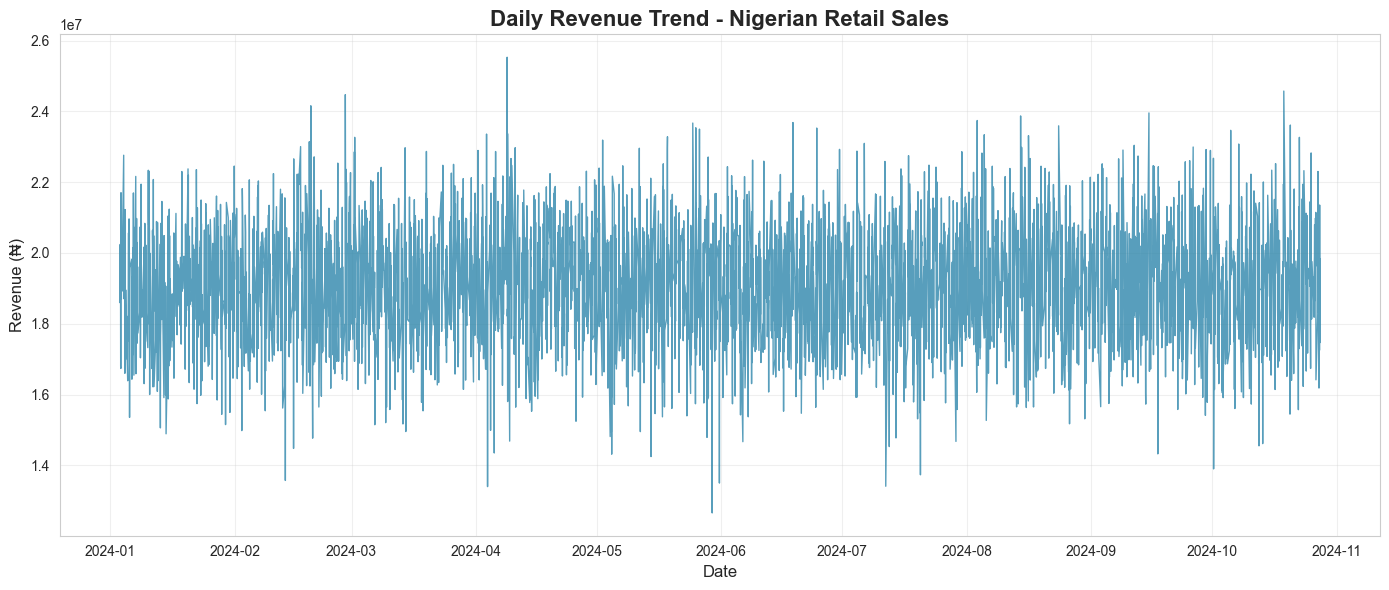

In [ ]:
# STEP 3: EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================
# --- Chart 1: Daily Revenue Trend Over Time ---
plt.figure(figsize=(14, 6))
plt.plot(daily_revenue['date'], daily_revenue['revenue'], linewidth=1, color='#2E86AB', alpha=0.8)
plt.title('Daily Revenue Trend - Nigerian Retail Sales', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue (₦)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


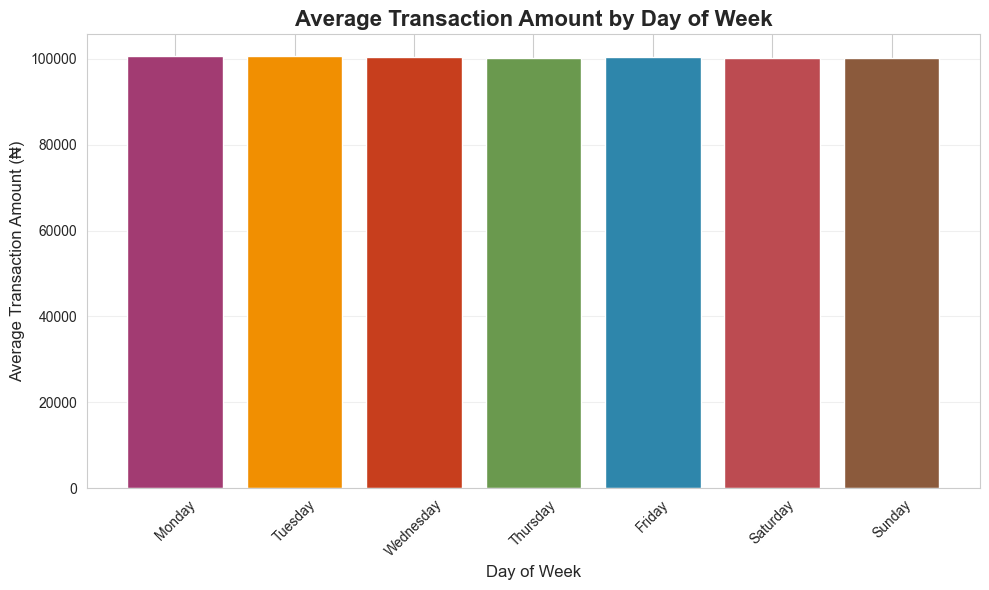

In [15]:

# --- Chart 2: Average Revenue by Day of Week ---
# Prepare data: calculate mean revenue for each day
avg_by_day = df.copy()
avg_by_day['transaction_date'] = pd.to_datetime(avg_by_day['transaction_date'])
avg_by_day['day_of_week'] = avg_by_day['transaction_date'].dt.dayofweek
avg_by_day_grouped = avg_by_day.groupby('day_of_week')['total_amount_ngn'].mean().reset_index()

# Map day numbers to names for better readability
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_by_day_grouped['day_name'] = avg_by_day_grouped['day_of_week'].map(lambda x: day_names[x])

plt.figure(figsize=(10, 6))
bars = plt.bar(avg_by_day_grouped['day_name'], avg_by_day_grouped['total_amount_ngn'], 
               color=['#A23B72', '#F18F01', '#C73E1D', '#6A994E', '#2E86AB', '#BC4B51', '#8B5A3C'])
plt.title('Average Transaction Amount by Day of Week', fontsize=16, fontweight='bold')
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Transaction Amount (₦)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

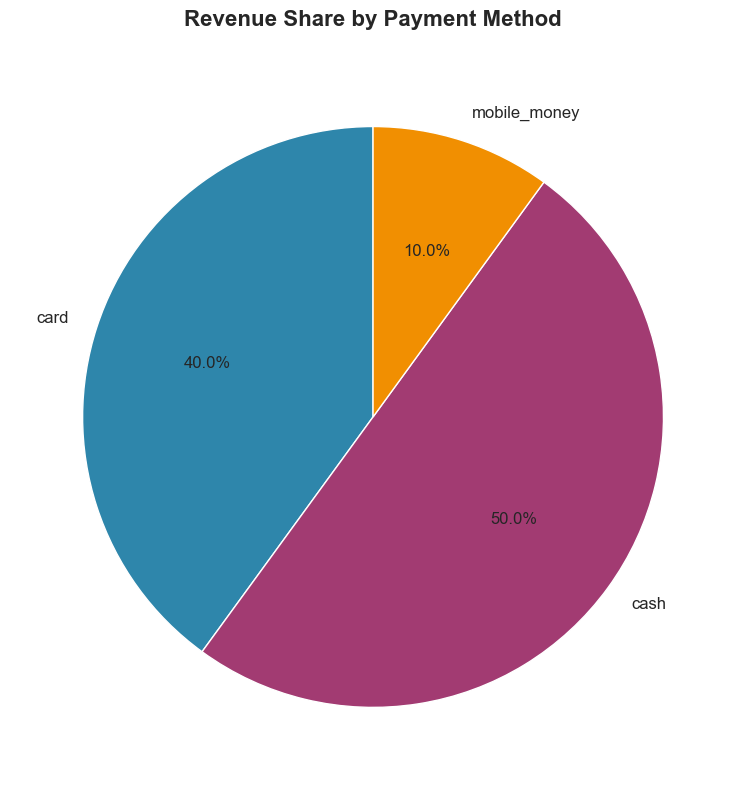

In [ ]:
# --- Chart 3: Revenue Share by Payment Method ---
payment_revenue = df.groupby('payment_method')['total_amount_ngn'].sum()
colors = ['#2E86AB', '#A23B72', '#F18F01']

plt.figure(figsize=(8, 8))
plt.pie(payment_revenue, labels=payment_revenue.index, autopct='%1.1f%%', 
        startangle=90, colors=colors, textprops={'fontsize': 12})
plt.title('Revenue Share by Payment Method', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [20]:
# ============================================================================
# STEP 4: PREPARE DATA FOR MACHINE LEARNING
# ============================================================================

# Define feature columns (X) and target column (y)
feature_cols = ['day_of_week', 'month', 'week_number', 'is_weekend', 
                'lag_7', 'lag_14', 'rolling_mean_7']
X = daily_revenue[feature_cols]
y = daily_revenue['revenue']

# Split data: 80% for training, 20% for testing
# We use the model's predictions on the test set to evaluate performance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
# shuffle=False preserves time order, which is important for time-series data

print(f"✓ Training set: {len(X_train)} days")
print(f"✓ Test set: {len(X_test)} days")


✓ Training set: 3348 days
✓ Test set: 838 days


In [25]:
# ============================================================================
# STEP 5: TRAIN XGBOOST FORECASTING MODEL
# ============================================================================
# Initialize XGBoost regressor with optimized parameters
model = xgb.XGBRegressor(
    n_estimators=100,      # Number of trees (more trees = better fit but slower)
    learning_rate=0.1,     # Step size for each tree (lower = more robust)
    max_depth=5,           # Maximum depth of each tree (controls complexity)
    random_state=42,       # For reproducibility
    objective='reg:squarederror'  # We're doing regression (predicting continuous values)
)

# Train the model on training data
model.fit(X_train, y_train)
print("✓ Model training completed")

# Make predictions on the test set
y_pred = model.predict(X_test)
print("✓ Predictions generated for test set")


✓ Model training completed
✓ Predictions generated for test set


In [26]:
# ============================================================================
# STEP 6: EVALUATE MODEL PERFORMANCE
# ============================================================================
print("\n[STEP 6] Evaluating model performance...")

# Calculate error metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # Mean Absolute Percentage Error

print("\n" + "="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)
print(f"Mean Absolute Error (MAE):  ₦{mae:,.2f}")
print(f"  → On average, predictions are off by ₦{mae:,.2f}")
print(f"\nRoot Mean Squared Error (RMSE): ₦{rmse:,.2f}")
print(f"  → Penalizes large errors more than MAE")
print(f"\nMean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"  → On average, predictions are {mape:.2f}% off from actual values")
print("="*60)



[STEP 6] Evaluating model performance...

MODEL PERFORMANCE METRICS
Mean Absolute Error (MAE):  ₦1,364,681.72
  → On average, predictions are off by ₦1,364,681.72

Root Mean Squared Error (RMSE): ₦1,709,750.31
  → Penalizes large errors more than MAE

Mean Absolute Percentage Error (MAPE): 7.21%
  → On average, predictions are 7.21% off from actual values


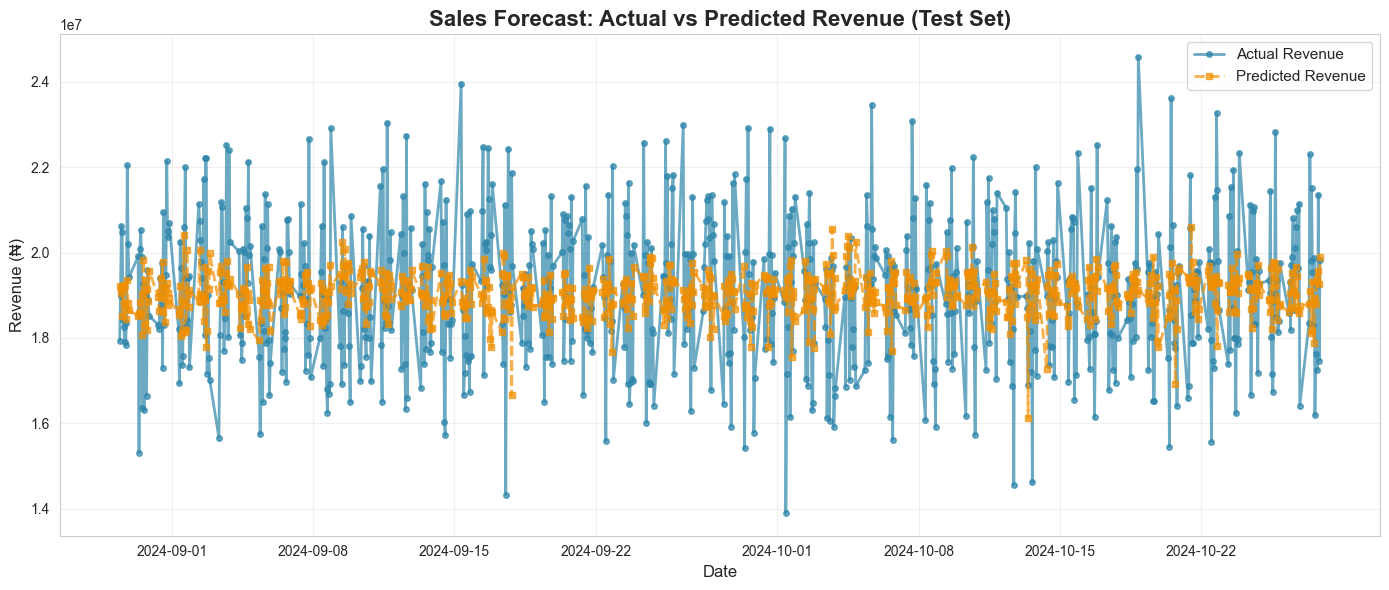

In [ ]:
# ============================================================================
# STEP 7: VISUALIZE FORECAST RESULTS
# ============================================================================

# Create a comparison plot of actual vs predicted revenue
plt.figure(figsize=(14, 6))

# Get the dates for the test set using y_test index
test_dates = daily_revenue.loc[y_test.index, 'date'].values

# Plot actual revenue
plt.plot(test_dates, y_test.values, label='Actual Revenue', 
         linewidth=2, color='#2E86AB', marker='o', markersize=4, alpha=0.7)

# Plot predicted revenue
plt.plot(test_dates, y_pred, label='Predicted Revenue', 
         linewidth=2, color='#F18F01', marker='s', markersize=4, linestyle='--', alpha=0.7)

plt.title('Sales Forecast: Actual vs Predicted Revenue (Test Set)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue (₦)', fontsize=12)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



Feature Importance Ranking:
----------------------------------------
lag_7                : 0.1921
rolling_mean_7       : 0.1905
week_number          : 0.1851
lag_14               : 0.1763
day_of_week          : 0.1317
month                : 0.1244
is_weekend           : 0.0000


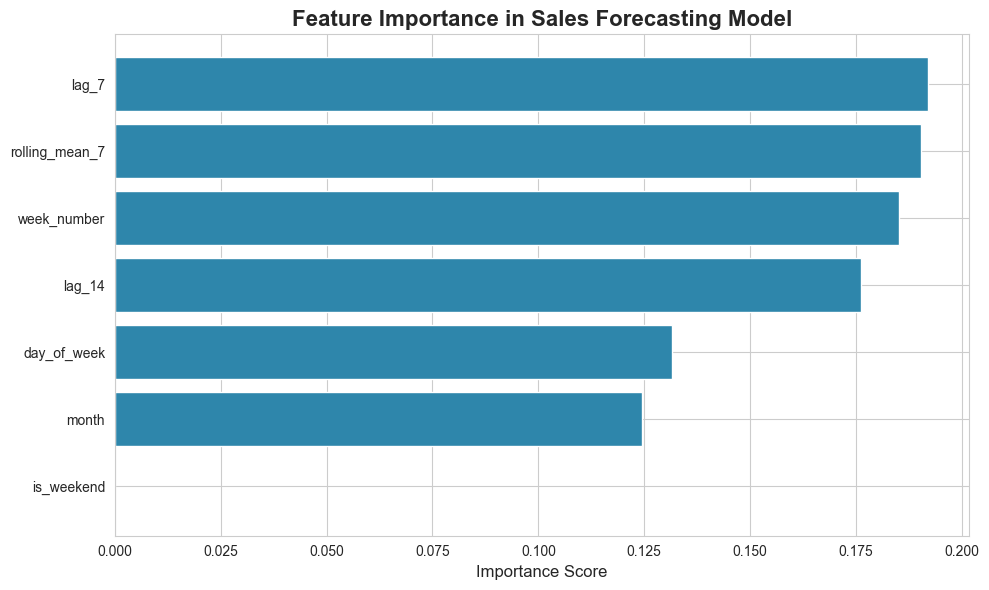

In [31]:
# ============================================================================
# STEP 8: FEATURE IMPORTANCE ANALYSIS
# ============================================================================

# XGBoost provides feature importance scores showing which features contribute most
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance Ranking:")
print("-" * 40)
for idx, row in feature_importance.iterrows():
    print(f"{row['feature']:20s} : {row['importance']:.4f}")

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='#2E86AB')
plt.xlabel('Importance Score', fontsize=12)
plt.title('Feature Importance in Sales Forecasting Model', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()


In [33]:

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\nKey Insights:")
print(f"  • Analyzed {len(df):,} transactions across {len(daily_revenue)} days")
print(f"  • Built XGBoost model with {len(feature_cols)} time-series features")
print(f"  • Achieved {mape:.2f}% average prediction error (MAPE)")
print(f"  • Most important feature: {feature_importance.iloc[0]['feature']}")
print("\nThis project demonstrates:")
print("  ✓ Data preprocessing and aggregation")
print("  ✓ Time-series feature engineering")
print("  ✓ Exploratory data analysis")
print("  ✓ Machine learning with XGBoost")
print("  ✓ Model evaluation and interpretation")
print("="*60)



Key Insights:
  • Analyzed 800,000 transactions across 4186 days
  • Built XGBoost model with 7 time-series features
  • Achieved 7.21% average prediction error (MAPE)
  • Most important feature: lag_7

This project demonstrates:
  ✓ Data preprocessing and aggregation
  ✓ Time-series feature engineering
  ✓ Exploratory data analysis
  ✓ Machine learning with XGBoost
  ✓ Model evaluation and interpretation
